<a href="https://colab.research.google.com/github/YX-Niu/SEtrash/blob/main/AutomatingRecycling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update
!apt-get install -y libheif-dev
!pip install pyheif pillow

!git clone https://github.com/garythung/trashnet.git
!git clone https://github.com/pedropro/TACO.git
!git clone https://github.com/YX-Niu/SEtrash.git

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
import os
import shutil
import zipfile
import pyheif
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

**Dataset Extraction**

The TrashNet dataset is provided as a ZIP file. If the dataset file exists, it is unzipped into the /content/trashnet/ directory to make the image files accessible for further processing. The categories of the dataset are then checked by listing the contents of the extracted directory.

In [ ]:
# Unzip TrashNet dataset
trashnet_zip = "/content/trashnet/data/dataset-resized.zip"
if os.path.exists(trashnet_zip):
    with zipfile.ZipFile(trashnet_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/trashnet/")
    print("TrashNet Unzipped Successfully!")

# Unzip SEtrash dataset
setrash_zip = "/content/SEtrash/trash_dataset.zip"
if os.path.exists(setrash_zip):
    with zipfile.ZipFile(setrash_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/SEtrash/")
    print("SEtrash Unzipped Successfully!")

# Process HEIC images (convert to JPG)
def convert_heic_to_jpg(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if not os.path.isdir(category_path):
            continue
        for img_file in os.listdir(category_path):
            print(img_file,category_path)
            if img_file.lower().endswith(".heic"):
                img_path = os.path.join(category_path, img_file)
                new_path = os.path.splitext(img_path)[0] + ".jpg"
                try:
                    heif_file = pyheif.read(img_path)
                    img = Image.frombytes(
                        heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride
                    )
                    img.save(new_path, "JPEG")
                    os.remove(img_path)  # Delete the original .HEIC file
                    print(f"Converted: {img_path} -> {new_path}")
                except Exception as e:
                    print(f"Failed to convert {img_path}: {e}")

convert_heic_to_jpg("/content/SEtrash/trash_dataset")

# Set data paths
dataset_dirs = {
    "TrashNet": "/content/trashnet/dataset-resized",
    "TACO": "/content/TACO/data",
    "SEtrash": "/content/SEtrash"
}

# Merge datasets, including the trash class
final_dataset_dir = "/content/final_dataset"
train_dir = os.path.join(final_dataset_dir, 'train')
test_dir = os.path.join(final_dataset_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

TrashNet Unzipped Successfully!
SEtrash Unzipped Successfully!
IMG_3866.HEIC /content/SEtrash/trash_dataset/cardboard
Converted: /content/SEtrash/trash_dataset/cardboard/IMG_3866.HEIC -> /content/SEtrash/trash_dataset/cardboard/IMG_3866.jpg
IMG_3869.HEIC /content/SEtrash/trash_dataset/cardboard
Converted: /content/SEtrash/trash_dataset/cardboard/IMG_3869.HEIC -> /content/SEtrash/trash_dataset/cardboard/IMG_3869.jpg
IMG_3867.HEIC /content/SEtrash/trash_dataset/cardboard
Converted: /content/SEtrash/trash_dataset/cardboard/IMG_3867.HEIC -> /content/SEtrash/trash_dataset/cardboard/IMG_3867.jpg
IMG_3887.HEIC /content/SEtrash/trash_dataset/paper
Converted: /content/SEtrash/trash_dataset/paper/IMG_3887.HEIC -> /content/SEtrash/trash_dataset/paper/IMG_3887.jpg
IMG_3862.HEIC /content/SEtrash/trash_dataset/paper
Converted: /content/SEtrash/trash_dataset/paper/IMG_3862.HEIC -> /content/SEtrash/trash_dataset/paper/IMG_3862.jpg
IMG_3888.HEIC /content/SEtrash/trash_dataset/paper
Converted: /content/

**Organizing Dataset into Category Folders**

Directories for each category (glass, cardboard, paper, metal, and plastic) are created within the destination directory (/content/trashnet/data). If the directories already exist, the code proceeds without error. The images from the extracted dataset are then moved into their respective category directories, ensuring that the images are organized for training.

In [ ]:
def split_dataset(source_dir, train_dir, test_dir, test_size=0.25):
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            images = [os.path.join(category_path, img) for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]

            if len(images) < 2:  # Check if there are enough images for splitting
                print(f"Skipping category '{category}' as it has fewer than 2 images.")
                continue  # Skip this category if it doesn't have enough images

            # Split into training and testing sets (75% train, 25% test)
            train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

            # Copy train images to train directory
            train_category_dir = os.path.join(train_dir, category)
            os.makedirs(train_category_dir, exist_ok=True)
            for img in train_images:
                shutil.copy(img, train_category_dir)

            # Copy test images to test directory
            test_category_dir = os.path.join(test_dir, category)
            os.makedirs(test_category_dir, exist_ok=True)
            for img in test_images:
                shutil.copy(img, test_category_dir)

#trash_dataset_path = os.path.join(train_dir, 'trash_dataset')
#if os.path.exists(trash_dataset_path):
    #shutil.rmtree(trash_dataset_path)
    #print("Deleted 'trash_dataset' folder from train directory.")


**Data Augmentation and Normalization**

Use ImageDataGenerator to improve the model's ability to generalize, data augmentation techniques are applied, including random rotation, shifting, shearing, zooming, and flipping of images. The pixel values are normalized to the range [0, 1] for consistency. The dataset is then split into training and validation sets, with 10% allocated for validation, and generators are created to load the data for training.

**Fine-Tuning MobileNetV2**

The pre-trained MobileNetV2 model is loaded with ImageNet weights, excluding its top layer to enable the addition of custom layers. All layers of the base model are unfrozen to allow fine-tuning. Custom layers include a Global Average Pooling layer, a Dense layer with 128 units, and a Dropout layer to prevent overfitting. The output layer consists of 6 units, corresponding to the 6 categories, and uses a softmax activation function. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss for multi-class classification.

In [ ]:
batch_size = 32
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize images to [0, 1]
    rotation_range=30,  # Randomly rotate images within a range
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Apply random shear transformations
    zoom_range=0.2,  # Apply random zoom
    horizontal_flip=True  # Randomly flip images horizontally
)

train_generator = train_datagen.flow_from_directory(
    '/content/final_dataset/train',
    target_size=img_size,  # Resize images
    batch_size=batch_size,  # Set batch size
    class_mode="categorical",  # Multi-class classification
    shuffle=True  # Shuffle the data
)

val_generator = train_datagen.flow_from_directory(
    '/content/final_dataset/test',
    target_size=img_size,  # Resize images
    batch_size=batch_size,  # Set batch size
    class_mode="categorical",  # Multi-class classification
    shuffle=False  # No need to shuffle validation data
)

print("Training set classes: ", train_generator.class_indices)
print("Validation set classes: ", val_generator.class_indices)


Found 1892 images belonging to 6 classes.
Found 635 images belonging to 6 classes.
Training set classes:  {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Validation set classes:  {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


**Model Training**

The model is trained for 10 epochs using the train_generator for training data and validation_generator for validation data. Class weights are applied to address class imbalance, ensuring the model pays more attention to underrepresented categories. Two callbacks, ReduceLROnPlateau and EarlyStopping, are used to adjust the learning rate and prevent overfitting by stopping training if the validation loss does not improve.

In [ ]:
categories = ['metal', 'trash', 'glass', 'cardboard', 'plastic', 'paper']
num_categories = len(categories)

# Build MobileNetV2 Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the pre-trained model weights

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_categories, activation='softmax')  # Use num_categories instead of categories
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define the model checkpoint callback
checkpoint = ModelCheckpoint('/content/best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with the checkpoint callback
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

# Evaluate the model
val_preds = model.predict(val_generator)
val_labels = np.argmax(val_preds, axis=1)
val_true = val_generator.classes


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5060 - loss: 1.2912

60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 612ms/step - accuracy: 0.5078 - loss: 1.2869 - val_accuracy: 0.7339 - val_loss: 0.7309
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7387 - loss: 0.7320

60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 486ms/step - accuracy: 0.7388 - loss: 0.7317 - val_accuracy: 0.7449 - val_loss: 0.6605
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7795 - loss: 0.5876

60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 511ms/step - accuracy: 0.7795 - loss: 0.5879 - val_accuracy: 0.7843 - val_loss: 0.5847
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8221 - loss: 0.5142

60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 486ms/step - accuracy: 0.8219 - loss: 0.5145 - val_accuracy: 0.7984 - val_loss: 0.5596
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 535ms/step - accuracy: 0.8216 - loss: 0.4793 - val_accuracy: 0.8047 - val_loss: 0.5613
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8343 - loss: 0.4763

60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 483ms/step - accuracy: 0.8343 - loss: 0.4759 - val_accuracy: 0.8047 - val_loss: 0.5400
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 486ms/step - accuracy: 0.8390 - loss: 0.4193 - val_accuracy: 0.7953 - val_loss: 0.5584
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 479ms/step - accuracy: 0.8518 - loss: 0.3962 - val_accuracy: 0.8000 - val_loss: 0.5453
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 477ms/step - accuracy: 0.8663 - loss: 0.3891 - val_accuracy: 0.8079 - val_loss: 0.5542
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8761 - loss: 0.3410

60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 497ms/step - accuracy: 0.8761 - loss: 0.3409 - val_accuracy: 0.8205 - val_loss: 0.5095
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8935 - loss: 0.3060

60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 485ms/step - accuracy: 0.8934 - loss: 0.3061 - val_accuracy: 0.8205 - val_loss: 0.4844
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 487ms/step - accuracy: 0.9012 - loss: 0.2913 - val_accuracy: 0.8157 - val_loss: 0.5355
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 477ms/step - accuracy: 0.8956 - loss: 0.2840 - val_accuracy: 0.7969 - val_loss: 0.5786
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 475ms/step - accuracy: 0.8992 - loss: 0.2998 - val_accuracy: 0.8236 - val_loss: 0.4882
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 495ms/step - accuracy: 0.8991 - loss: 0.2705 - val_accuracy: 0.8268 - val_loss: 0.4986
Epoch 16/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 477ms/step - accuracy: 0.9117 - loss: 0.2275 - val_accuracy: 0.8031 - val_loss: 0.5691
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step


**Model Evaluation and Results Visualization**

Accuracy and Loss Visualization: The training and validation accuracy and loss are plotted over the epochs to evaluate the model's learning progress. This helps to identify potential issues such as overfitting.
Model Saving: The fine-tuned model is saved to a file (trash_classifier_finetuned.h5) for future use.
Performance Metrics: A confusion matrix is created to visualize the true vs. predicted labels, and a classification report is generated to provide detailed performance metrics for each category. The classification report is saved as a text file for documentation and analysis.

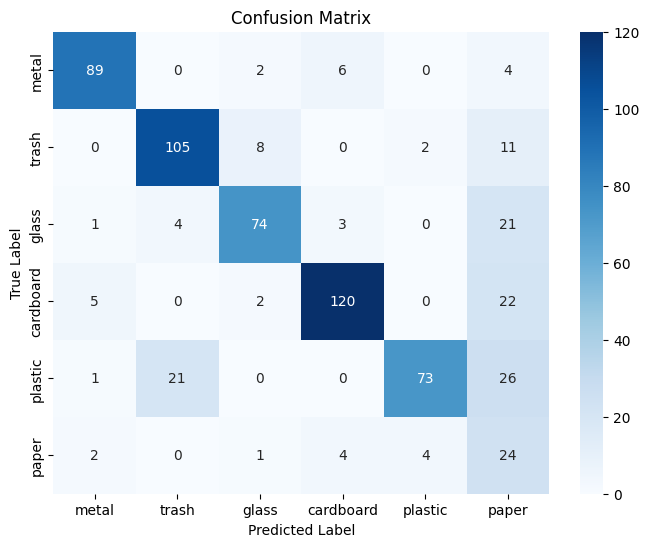

              precision    recall  f1-score   support

       metal       0.91      0.88      0.89       101
       trash       0.81      0.83      0.82       126
       glass       0.85      0.72      0.78       103
   cardboard       0.90      0.81      0.85       149
     plastic       0.92      0.60      0.73       121
       paper       0.22      0.69      0.34        35

    accuracy                           0.76       635
   macro avg       0.77      0.75      0.74       635
weighted avg       0.84      0.76      0.79       635



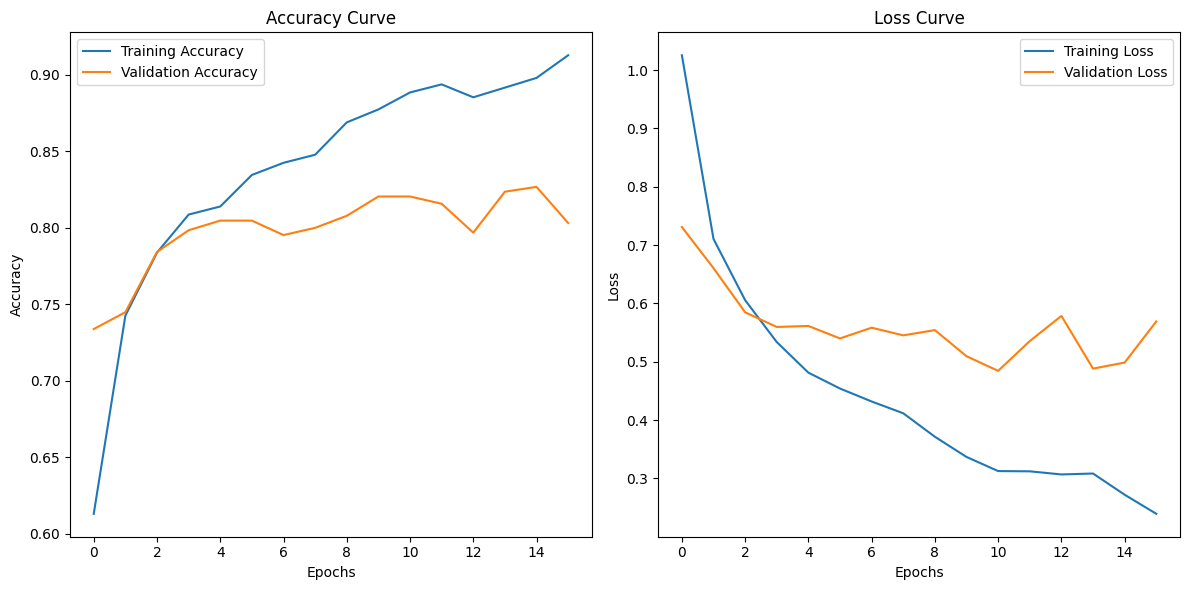

<ipython-input-57-d30a8a52b0a1>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=val_true, palette='Set2')


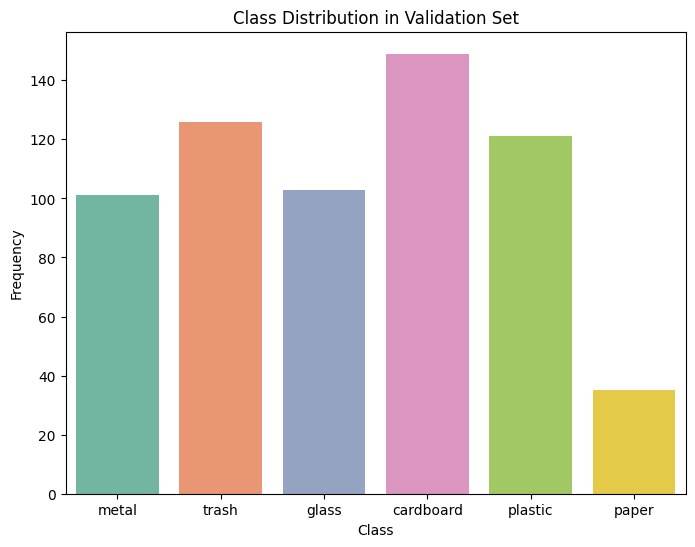

<ipython-input-57-d30a8a52b0a1>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=val_labels, palette='Set1')


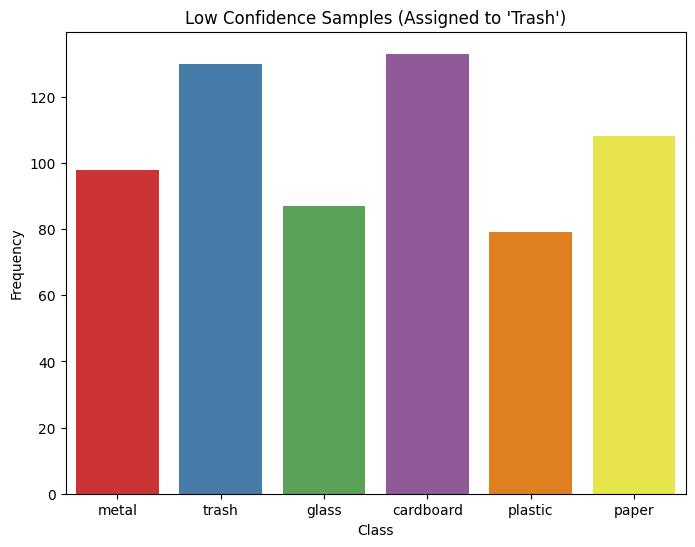

In [ ]:
# Calculate low confidence samples
low_confidence_threshold = 0.6
low_confidence_idx = np.where(np.max(val_preds, axis=1) < low_confidence_threshold)[0]

# Only modify the labels of low-confidence samples to "trash" (no file operations)
# Assign the "trash" class index (assuming trash is the 6th class, index 5) to low-confidence samples
for idx in low_confidence_idx:
    val_labels[idx] = 5  # Assume "trash" is the 6th class (index 5)

# Plot confusion matrix
cm = confusion_matrix(val_true, val_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display classification report
print(classification_report(val_true, val_labels, target_names=categories))

# Plot accuracy and loss curves for training process
plt.figure(figsize=(12, 6))

# Assuming history contains 'accuracy' and 'loss' metrics
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Plot class distribution in validation set
plt.figure(figsize=(8, 6))
sns.countplot(x=val_true, palette='Set2')
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot low confidence samples
plt.figure(figsize=(8, 6))
sns.countplot(x=val_labels, palette='Set1')
plt.title("Low Confidence Samples (Assigned to 'Trash')")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()


In [ ]:
categories = ['metal', 'trash', 'glass', 'cardboard', 'plastic', 'paper']
num_categories = len(categories)

# Build MobileNetV2 Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the pre-trained model weights

model = tf.keras.models.load_model('best_model.h5')

def preprocess_image(image):
    # Open the image using PIL
    image = Image.open(image)

    # Convert to RGB if image is in a different mode (e.g., RGBA)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize to 224x224
    image = image.resize((224, 224))

    # Convert to numpy array and preprocess
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image (assuming your model expects values in [0,1])
    img_array = img_array / 255.0

    return img_array

def prediction(image):
    processed_image = preprocess_image(image)

    # Make prediction
    predictions = model.predict(processed_image)

    # Get the highest confidence prediction
    predicted_class_index = np.argmax(predictions[0])
    confidence = float(predictions[0][predicted_class_index])

    return predictions[0]


In [ ]:

d = { 2: "/content/SEtrash/trash_dataset/glass/IMG_3864.jpg", 3: "/content/SEtrash/trash_dataset/cardboard/IMG_3866.jpg", 0: "/content/SEtrash/trash_dataset/metal/IMG_3872.jpg", 1: "/content/SEtrash/trash_dataset/trash/IMG_3875.jpg",
     4: "/content/SEtrash/trash_dataset/plastic/IMG_3873.jpg", 5: "/content/SEtrash/trash_dataset/paper/IMG_3888.jpg"}
for k,v in d.items():
    p = [ (pr,index) for index,pr in enumerate(prediction(v)) ]
    p.sort(reverse=True)
    p = p[:3]
    print(categories[k])
    for i in p:
        print(f'{categories[i[1]]}: {i[0]*100:.1f} %')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
glass
trash: 99.7 %
glass: 0.1 %
plastic: 0.1 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
cardboard
cardboard: 92.4 %
glass: 6.8 %
plastic: 0.3 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
metal
glass: 72.5 %
trash: 17.5 %
cardboard: 8.7 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
trash
plastic: 49.3 %
paper: 23.3 %
cardboard: 19.2 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
plastic
trash: 73.9 %
plastic: 24.1 %
glass: 1.6 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
paper
paper: 48.4 %
cardboard: 29.5 %
metal: 22.0 %
